ursprüngliche auswertung vieler modelle zeitgleich basierend auf dem mittleren durchmesser verglichen mit manuell gemenssenem Durchmesser

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 896ms/step
Bild: hanging drop mittlere 3 Zellzahlen mit und ohne Rock_Tag 1_3.000 mit Rock_B8_ch00.tif, Durchmesser (Pixel): 63.607082095583266, Durchmesser (µm): 119.86950610234372
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step
Bild: hanging drop mittlere 3 Zellzahlen mit und ohne Rock_Tag 1_3.000 mit Rock_D7_ch00.tif, Durchmesser (Pixel): 63.272653329341274, Durchmesser (µm): 119.23926478777433
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
Bild: hanging drop mittlere 3 Zellzahlen mit und ohne Rock_Tag 1_3.000 mit Rock_E7_ch00.tif, Durchmesser (Pixel): 64.08678019723142, Durchmesser (µm): 120.77351195559743
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
Bild: hanging drop mittlere 3 Zellzahlen mit und ohne Rock_Tag 1_3.000 mit Rock_E8_ch00.tif, Durchmesser (Pixel): 66.54602647528013, Durchmesser (µm): 125.40803734210617
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step
Bild: hanging drop mittlere 3 Zellzahlen mit und ohne Rock_Tag 1_3.000 mit Rock_F7_ch00.tif, Durchmesser (Pixel): 66.585864

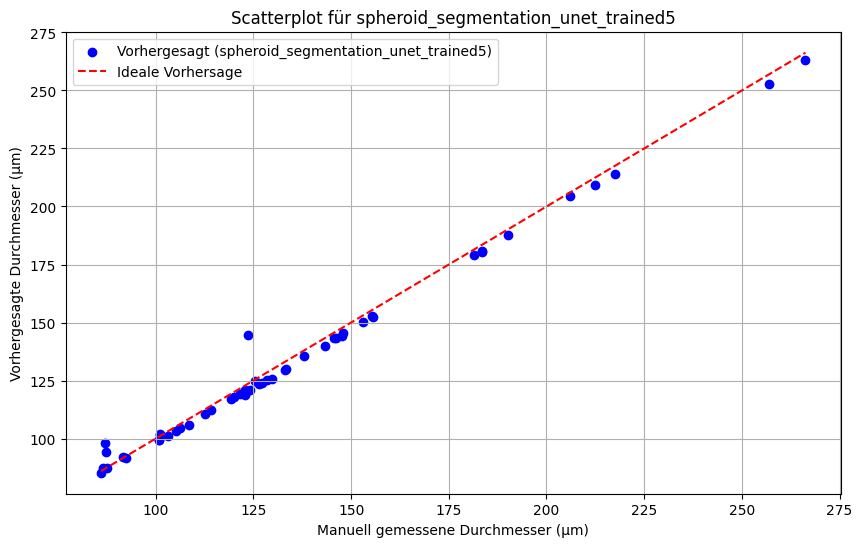

Scatterplot für spheroid_segmentation_unet_trained5 gespeichert unter: C:/Users/chris/Documents/Master/Sphaeroidauswertung/Ergebnisse/Segmentierte_Bilder_mit_dropout_3 beste bisher test/scatter_spheroid_segmentation_unet_trained5.png
Alle Ergebnisse und Scatterplots wurden gespeichert in C:/Users/chris/Documents/Master/Sphaeroidauswertung/Ergebnisse/Durchmesser_Liste_Multiple_Modelle.xlsx.
Model: spheroid_segmentation_unet_trained5, R²: 0.9895, MAE: 3.0071


In [1]:
import os
import numpy as np
import cv2
import pandas as pd
from PIL import Image
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model



# Funktionen für Bildbearbeitung und Maskenerstellung
def draw_contours_and_centroid(binary_mask, output_path):
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    color_mask = cv2.cvtColor(binary_mask, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(color_mask, contours, -1, (0, 255, 0), 2)
    
    for contour in contours:
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            cv2.circle(color_mask, (cX, cY), 5, (0, 0, 255), -1)
    cv2.imwrite(output_path, color_mask)

# Dice Metric
def dice_metric(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice

# Benutzerdefinierte Verlustfunktion
def combined_loss(y_true, y_pred, smooth=1e-6, binary_weight=0.5, dice_weight=0.5):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    dice_loss = 1 - (2. * intersection + smooth) / (union + smooth)
    return binary_weight * bce + dice_weight * dice_loss

# Laden und Vorverarbeiten der Bilder
def load_and_preprocess_image_pillow(img_path):
    img = Image.open(img_path).convert('L')
    img = img.resize((256, 192))
    img = np.array(img)
    img = img / 255.0
    img = np.expand_dims(img, axis=-1)
    return img

# Vorhersage mit dem Modell machen
def predict_with_model(model, image):
    image = np.expand_dims(image, axis=0)
    predicted_mask = model.predict(image)
    return np.squeeze(predicted_mask)

# Funktion zur Berechnung des mittleren Durchmessers
def calculate_average_diameter(contour, center, num_lines=180):
    angles = np.linspace(0, 2 * np.pi, num=num_lines, endpoint=False)
    diameters = []
    for angle in angles:
        dx = np.cos(angle)
        dy = np.sin(angle)
        intersections = []
        for i in range(-1000, 1000):
            x = int(center[0] + i * dx)
            y = int(center[1] + i * dy)
            if cv2.pointPolygonTest(contour, (x, y), False) >= 0:
                intersections.append((x, y))
        if len(intersections) >= 2:
            d = np.linalg.norm(np.array(intersections[0]) - np.array(intersections[-1]))
            diameters.append(d)
    return np.mean(diameters)

# mit mehreren Modellen vorhersagen und die berechnungen durchführen    
def process_models(model_paths, input_dir, output_dir, excel_file_path, output_excel_path):
    # Excel-Datei laden (manuelle Durchmesser)
    df_manual = pd.read_excel(excel_file_path, header=0)

    # Überprüfen, ob die 'Durchmesser'-Spalte numerische Werte enthält
    df_manual['Durchmesser'] = pd.to_numeric(df_manual['Durchmesser'], errors='coerce')
    df_manual.dropna(subset=['Durchmesser'], inplace=True)

    # Manuelle Durchmesser in eine Liste konvertieren
    manual_diameters = df_manual['Durchmesser'].tolist()

    # Skalierungsfaktoren berechnen
    scale_factor_width = 1296 / 256
    scale_factor_height = 966 / 196

    # TIFF-Dateien laden
    tif_files = [f for f in os.listdir(input_dir) if f.endswith('.tif')]

    if len(tif_files) != len(manual_diameters):
        print("Die Anzahl der Bilddateien stimmt nicht mit der Anzahl der manuellen Messungen überein.")
        return

    # Ergebnisse für jedes Modell speichern
    all_predicted_diameters = {}
    metrics = {}

    for model_path in model_paths:
        model_name = os.path.basename(model_path).replace('.h5', '')
        predicted_diameters = []

        # Modell laden und kompilieren (wegen dem custom loss)
        model = load_model(model_path, compile=False)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                      loss=lambda y_true, y_pred: combined_loss(y_true, y_pred, binary_weight=0.5, dice_weight=0.5),
                      metrics=[])

        for i, filename in enumerate(tif_files):
            img_path = os.path.join(input_dir, filename)
            try:
                # Bild laden und vorverarbeiten
                image = load_and_preprocess_image_pillow(img_path)
                predicted_mask = predict_with_model(model, image)  # Vorhersage mit dem Modell

                if predicted_mask is None:
                    print(f"Fehler bei der Vorhersage für {filename}.")
                    continue

                contours, _ = cv2.findContours((predicted_mask > 0.5).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

                if not contours:
                    print(f"Keine Konturen im Bild {filename} gefunden.")
                    continue

                largest_contour = max(contours, key=cv2.contourArea)
                M = cv2.moments(largest_contour)
                if M["m00"] == 0:
                    print(f"Momentenberechnung ergibt 0 für Bild {filename}.")
                    continue
                center = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))

                avg_diameter_pixels = calculate_average_diameter(largest_contour, center)
                avg_diameter_micrometers = avg_diameter_pixels * (0.3745 * scale_factor_width) * 0.994

                # Print-Anweisung für die berechneten Durchmesser
                print(f"Bild: {filename}, Durchmesser (Pixel): {avg_diameter_pixels}, Durchmesser (µm): {avg_diameter_micrometers}")

                predicted_diameters.append(avg_diameter_micrometers)

                output_path = os.path.join(output_dir, f"{os.path.splitext(filename)[0]}_{model_name}_segmentiert.tif")
                draw_contours_and_centroid((predicted_mask > 0.5).astype(np.uint8) * 255, output_path)

            except Exception as e:
                print(f"Fehler bei der Verarbeitung von {filename}: {e}")

        all_predicted_diameters[model_name] = predicted_diameters

        # Berechnung der Metriken 
        r2 = r2_score(manual_diameters, predicted_diameters)
        mae = mean_absolute_error(manual_diameters, predicted_diameters)
        metrics[model_name] = {'R²': r2, 'MAE': mae}

        print(f"Model: {model_name}, Anzahl der vorhergesagten Durchmesser: {len(predicted_diameters)}, Werte: {predicted_diameters}")

    # Scatterplot für alle Modelle erstellen
    create_scatterplots(manual_diameters, all_predicted_diameters, metrics, output_dir)

    # Ergebnisse in DataFrame konvertieren und exportieren
    df_results = pd.DataFrame(all_predicted_diameters)
    df_results.insert(0, 'Manuell gemessene Durchmesser (µm)', manual_diameters)
    df_results.to_excel(output_excel_path, index=False)

    print(f"Alle Ergebnisse und Scatterplots wurden gespeichert in {output_excel_path}.")

    # Metriken ausgeben
    for model_name, metric in metrics.items():
        print(f"Model: {model_name}, R²: {metric['R²']:.4f}, MAE: {metric['MAE']:.4f}")

# Funktion zum Erstellen von Scatterplots
def create_scatterplots(manual_diameters, all_predicted_diameters, metrics, output_dir):
    for model_name, predicted_diameters in all_predicted_diameters.items():
        plt.figure(figsize=(10, 6))
        plt.scatter(manual_diameters, predicted_diameters, color='blue', label=f'Vorhergesagt ({model_name})')
        plt.plot([min(manual_diameters), max(manual_diameters)], [min(manual_diameters), max(manual_diameters)], color='red', linestyle='--', label='Ideale Vorhersage')
        plt.xlabel('Manuell gemessene Durchmesser (µm)')
        plt.ylabel('Vorhergesagte Durchmesser (µm)')
        plt.title(f'Scatterplot für {model_name}')
        plt.legend()
        plt.grid(True)

        scatter_output_path = os.path.join(output_dir, f'scatter_{model_name}.png')
        plt.savefig(scatter_output_path)
        plt.show()
        plt.close()
        print(f"Scatterplot für {model_name} gespeichert unter: {scatter_output_path}")

model_paths = [

    'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Modelle/spheroid_segmentation_unet_trained5.h5',
  
]

input_dir = "C:/Users/chris/Documents/Master/Sphaeroidauswertung/Trainingsset/Testset von julia"
output_dir = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Ergebnisse/Segmentierte_Bilder_mit_dropout_3 beste bisher test/'
excel_file_path = 'C:/Users/chris/Documents/Testset.xlsx'
output_excel_path = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Ergebnisse/Durchmesser_Liste_Multiple_Modelle.xlsx'

process_models(model_paths, input_dir, output_dir, excel_file_path, output_excel_path)


Berechnung von Dice und Jaccard Koeffizient aus Ground Truth Maske und Vorhergesagter Maske


In [ ]:
import numpy as np

# Beispiel für eine einzelne Vorhersagemaske und eine Ground-Truth-Maske (als 2D-Arrays mit 0 und 1)
# pred_mask und true_mask sind binäre Arrays mit den Dimensionen des Bildes
def calculate_tp_fp_fn(pred_mask, true_mask):
    TP = np.sum((pred_mask == 1) & (true_mask == 1))  # Pixel, die in beiden Masken 1 sind
    FP = np.sum((pred_mask == 1) & (true_mask == 0))  # Pixel, die nur in der Vorhersagemaske 1 sind
    FN = np.sum((pred_mask == 0) & (true_mask == 1))  # Pixel, die nur in der Ground-Truth-Maske 1 sind
    return TP, FP, FN

# Berechnung des Dice-Koeffizienten und Jaccard-Index (IoU)
def dice_coefficient(TP, FP, FN):
    dice = (2 * TP) / (2 * TP + FP + FN) if (2 * TP + FP + FN) != 0 else 0
    return dice

def jaccard_index(TP, FP, FN):
    iou = TP / (TP + FP + FN) if (TP + FP + FN) != 0 else 0
    return iou

# Beispiel für die Berechnung über das gesamte Testset
dice_scores = []
iou_scores = []

# Annahme: pred_masks und true_masks sind Listen der vorhergesagten und Ground-Truth-Masken für alle 500 Bilder
for pred_mask, true_mask in zip(pred_masks, true_masks):
    TP, FP, FN = calculate_tp_fp_fn(pred_mask, true_mask)
    dice = dice_coefficient(TP, FP, FN)
    iou = jaccard_index(TP, FP, FN)
    dice_scores.append(dice)
    iou_scores.append(iou)

# Durchschnittswerte über das gesamte Testset
mean_dice = np.mean(dice_scores)
mean_iou = np.mean(iou_scores)

print(f"Durchschnittlicher Dice-Koeffizient: {mean_dice}")
print(f"Durchschnittlicher Jaccard-Index (IoU): {mean_iou}")

# Vorhergesate maske muss hochskaliert werden für sinnvolle vergleichbarkeit

import cv2
import numpy as np

# Funktion zum Upscaling einer binären Vorhersagemaske auf die Größe der Ground-Truth-Maske
def upscale_mask(pred_mask, target_shape):
    # Interpolation auf die Zielgröße mit Nearest Neighbor
    return cv2.resize(pred_mask, dsize=(target_shape[1], target_shape[0]), interpolation=cv2.INTER_NEAREST)

# Beispiel: pred_mask ist die herunterskalierte Vorhersagemaske, true_mask ist die Ground-Truth-Maske in Originalgröße
# Nehmen wir an, beide Masken sind binär (0 und 1 für Hintergrund und Objekt)

for pred_mask, true_mask in zip(pred_masks, true_masks):
    # Hochskalieren der Vorhersagemaske
    upscaled_pred_mask = upscale_mask(pred_mask, true_mask.shape)
    
    # TP, FP und FN bestimmen
    TP = np.sum((upscaled_pred_mask == 1) & (true_mask == 1))
    FP = np.sum((upscaled_pred_mask == 1) & (true_mask == 0))
    FN = np.sum((upscaled_pred_mask == 0) & (true_mask == 1))
    
    # Metriken berechnen
    dice = dice_coefficient(TP, FP, FN)
    iou = jaccard_index(TP, FP, FN)

    # Ergebnis speichern oder auswerten
    dice_scores.append(dice)
    iou_scores.append(iou)

# Durchschnittswerte über das gesamte Testset berechnen
mean_dice = np.mean(dice_scores)
mean_iou = np.mean(iou_scores)

print(f"Durchschnittlicher Dice-Koeffizient: {mean_dice}")
print(f"Durchschnittlicher Jaccard-Index (IoU): {mean_iou}")
